## Setup

In [154]:
%pip install swifter neuralprophet plotly kaleido statsmodels pmdarima swifter matplotlib seaborn plotly numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [155]:
import os
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt
import swifter
import dateutil
import datetime
import plotly
import tqdm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split

from lightning.pytorch.tuner import Tuner
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import torch
pl.seed_everything(19)
import pytorch_forecasting as ptf

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet, NBeats
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, MAPE, RMSE, SMAPE, NormalDistributionLoss

Seed set to 19


## Data preparation

### Loading data

In [156]:
df_tribunal = pd.read_csv('dados/processados/serie_temporal_ajuizamento-TJRN_G1_2018.csv', header='infer', sep=';')
df_tribunal.drop(columns=['Unnamed: 0', 'numero_processo', 'tribunal', 'classe_codigo', 'codigo_orgaoJulgador', 'grau'], inplace=True)
print(df_tribunal.head(2))
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(dateutil.parser.parse)
#df_tribunal['data_ajuizamento'] = df_tribunal['data_ajuizamento'].swifter.apply(datetime.datetime.date)


  data_ajuizamento
0       2018-04-23
1       2019-06-20


In [157]:
df_tribunal = df_tribunal[df_tribunal['data_ajuizamento'] < '2025-01-01']

In [158]:
dataframe = df_tribunal.groupby(['data_ajuizamento']).size()
df_tribunal = dataframe.to_frame(name='quantidade')
df_tribunal = df_tribunal.rename_axis('data_ajuizamento').reset_index()
print(df_tribunal)

     data_ajuizamento  quantidade
0          2018-01-01           8
1          2018-01-02          73
2          2018-01-03          82
3          2018-01-04         122
4          2018-01-05          12
...               ...         ...
2310       2024-05-03         320
2311       2024-05-04          91
2312       2024-05-05          51
2313       2024-05-06         559
2314       2024-05-07         383

[2315 rows x 2 columns]


In [159]:
#df_tribunal['data_ajuizamento'] = pd.to_datetime(df_tribunal['data_ajuizamento'])

### Visualização dos dados

Série Temporal dos ajuizamentos ao longo do tempo

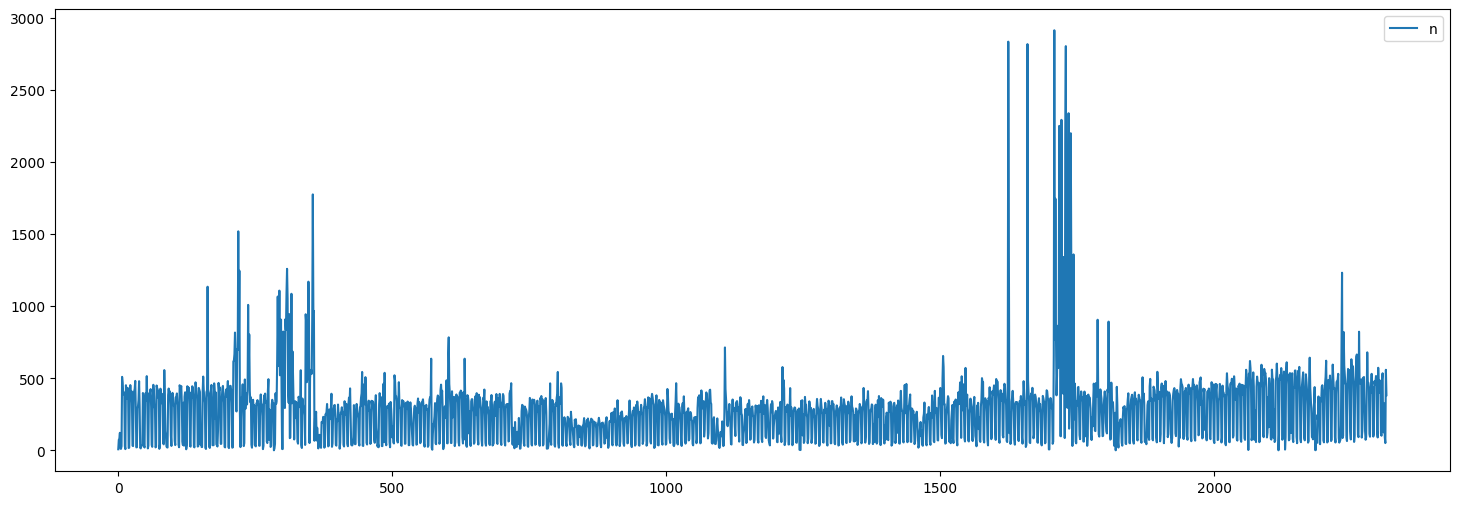

In [160]:
plt.figure(figsize=(18, 6))
plt.plot(df_tribunal['quantidade'])
plt.legend('número de ajuizamentos')

## Análise estatística

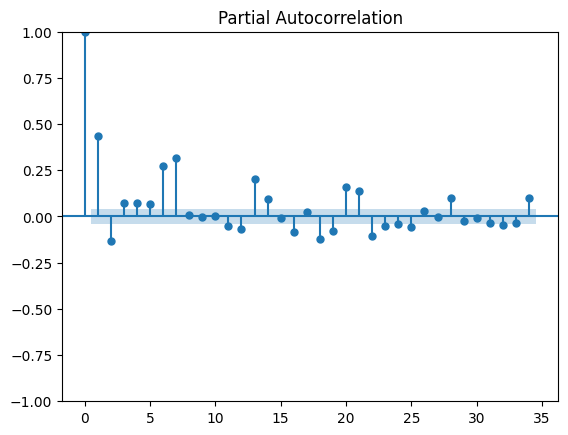

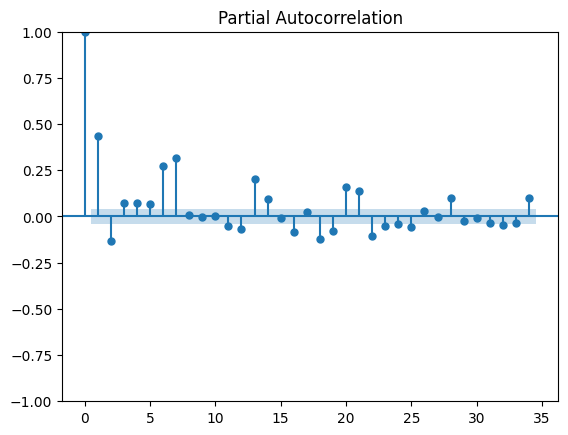

In [161]:
## PACF

df_pacf = df_tribunal
df_pacf.set_index('data_ajuizamento', inplace=True)
plot_pacf(df_pacf)

In [162]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_pacf.quantidade.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

if pval < 0.5:
    print('\n\nA série temporal é estacionária')
else:
    print('\n\nA série temporal não é estacionária')

ADF test statistic: -5.978759473026035
ADF p-values: 1.860132850939429e-07
ADF number of lags used: 27
ADF number of observations: 2287
ADF critical values: {'1%': -3.4332125513481744, '5%': -2.86280460821553, '10%': -2.5674432086780112}
ADF best information criterion: 30320.37777572633


A série temporal é estacionária


# Métodos e modelos

## PyTorch Forecasting
### DeepAR

In [163]:
data = df_pacf.reset_index()
data['data_ajuizamento'] = data['data_ajuizamento'].swifter.apply(dateutil.parser.parse)
data['idx'] = range(len(data))
data['group'] = 0
data['quantidade'] = data['quantidade'].astype(np.float64)
torch.set_float32_matmul_precision('medium')
                                   
# create dataset and dataloaders
max_encoder_length = 180
max_prediction_length = 30

training_cutoff = data["idx"].max() - max_prediction_length
print((training_cutoff))
context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.idx <= training_cutoff],
    time_idx="idx",
    target="quantidade",
    categorical_encoders={"group": NaNLabelEncoder().fit(data.group)},
    group_ids=['group'],
    time_varying_unknown_reals=["quantidade"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1, predict=True, stop_randomization=True)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
print('SMAPE (Baseline): ' + str(SMAPE()(baseline_predictions.output, baseline_predictions.y)))

Pandas Apply:   0%|          | 0/2315 [00:00<?, ?it/s]

2284


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SMAPE (Baseline): tensor(0.9681, device='cuda:0')


In [164]:
trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=1e-1, limit_train_batches=200, max_epochs=1, fast_dev_run=False, enable_progress_bar=True)

net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=50,
    rnn_layers=3,
    loss=NormalDistributionLoss(),
    optimizer="Adam",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0018620871366628671
Restoring states from the checkpoint path at /opt/spark/tcc/tcc_cesar/.lr_find_a959cf1e-4f16-47f6-b0ba-602fedebda81.ckpt
Restored all states from the checkpoint at /opt/spark/tcc/tcc_cesar/.lr_find_a959cf1e-4f16-47f6-b0ba-602fedebda81.ckpt


suggested learning rate: 0.0018620871366628671


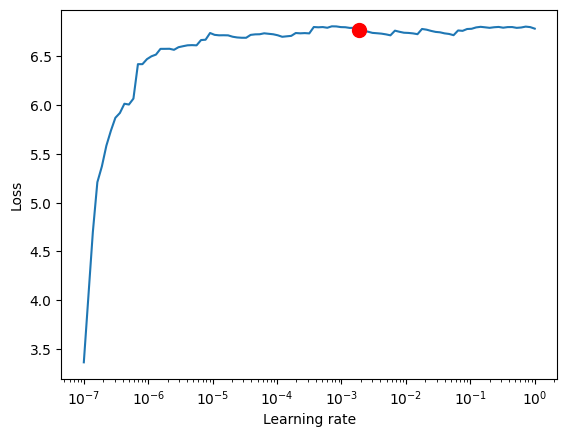

In [165]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-7,
    max_lr=1e0,
    early_stop_threshold=300,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [166]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=150,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=25,
    rnn_layers=2,
    optimizer="Adam",
    loss=NormalDistributionLoss(),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 8.0 K 
4 | distribution_projector | Linear                 | 52    
------------------------------------------------------------------
8.1 K     Trainable params
0         Non-trainable params
8.1 K     Total params
0.032     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [167]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
print('MAE: ' + str(MAE()(predictions.output, predictions.y)))
print('MAPE: ' + str(MAPE()(predictions.output, predictions.y)))
print('RMSE: ' + str(RMSE()(predictions.output, predictions.y)))
print('SMAPE: ' + str(SMAPE()(predictions.output, predictions.y)))

raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=30, trainer_kwargs=dict(accelerator="gpu")
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE: tensor(72.7543, device='cuda:0')
MAPE: tensor(0.3026, device='cuda:0')
RMSE: tensor(106.7794, device='cuda:0')
SMAPE: tensor(0.2278, device='cuda:0')


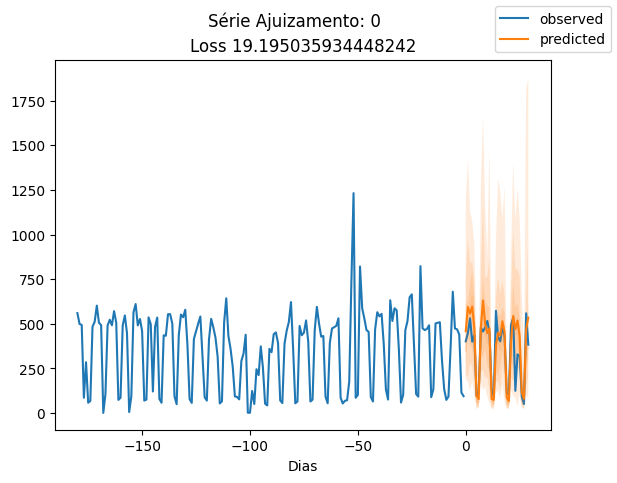

In [168]:
series = validation.x_to_index(raw_predictions.x)["group"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Série Ajuizamento: {series.iloc[idx]}")
    plt.xlabel('Dias')

### N-Beats
Referência: https://arxiv.org/pdf/1905.10437

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 89 steps due to diverging loss.
Learning rate set to 0.0028183829312644535
Restoring states from the checkpoint path at /opt/spark/tcc/tcc_cesar/.lr_find_2849b016-41cc-4a76-8d3d-4000151190ae.ckpt
Restored all states from the checkpoint at /opt/spark/tcc/tcc_cesar/.lr_find_2849b016-41cc-4a76-8d3d-4000151190ae.ckpt


suggested learning rate: 0.0028183829312644535


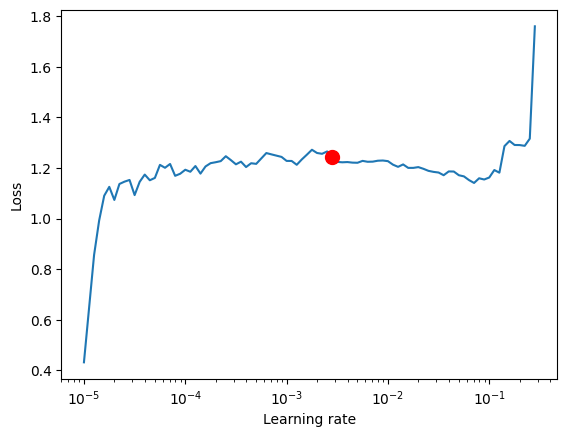

In [170]:
trainer = pl.Trainer(gradient_clip_val=0.01)
net = NBeats.from_dataset(training, 
                          learning_rate=3e-2, 
                          weight_decay=1e-2, 
                          widths=[32, 512], 
                          backcast_loss_ratio=0.1)

# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [172]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.9 M 
-----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.696     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [174]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
print('MAE: ' + str(MAE()(predictions.output, predictions.y)))
print('MAPE: ' + str(MAPE()(predictions.output, predictions.y)))
print('RMSE: ' + str(RMSE()(predictions.output, predictions.y)))
print('SMAPE: ' + str(SMAPE()(predictions.output, predictions.y)))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MAE: tensor(137.7821)
MAPE: tensor(0.4865)
RMSE: tensor(179.5511)
SMAPE: tensor(0.4278)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Text(0.5, 0, 'Número de dias')

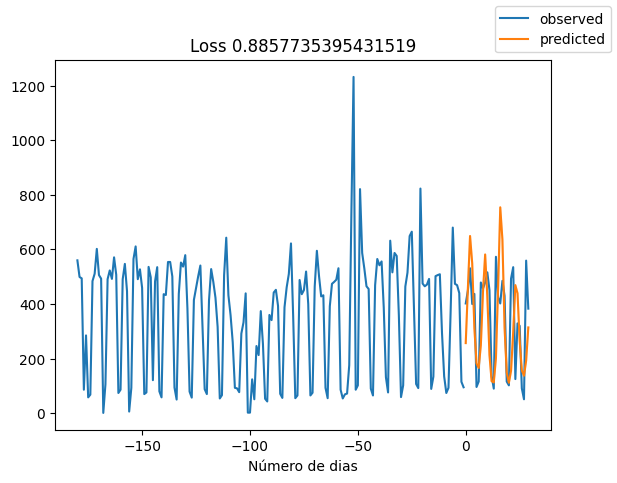

In [180]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="gpu"))
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    
plt.xlabel('Número de dias') 

Text(0.5, 0, 'Número de dias')

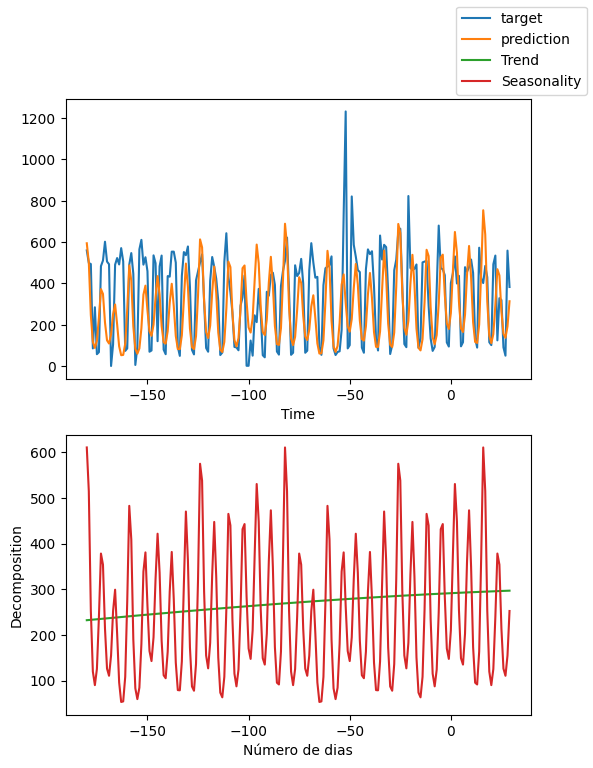

In [182]:
for idx in range(1):  # plot 10 examples
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)

plt.xlabel('Número de dias')    